# Introduction

The goal of this tutorial is to 1) Show how the figures and the results in the paper were generated in the section that explains predicting AD product using 16s data at time 0 using the study by Ding et al.  2) Show the pipeline for parameter tuning for the model that can be applied to a new study.

## Feed definitions

In ADToolbox Feed is defined by determining the percentage of the following quantities: 

- Carbohydrates
- Proteins
- Lipids
- xi (percentage of TSS that is inert. i.e. ash)
- si (percentage of TDS that is inert.)
- tss (percentage of total cod that is not soluble)

Having these quantities, the feed can be instatiated as it is explained later. 

In the study by Ding et al. the feed characteristics that we could find, that were relevent to our AD model, are the following. Some of the inputs of ADM was approximated from other U.S food waste studies:

- total COD = 18 gCOD/l (Mentioned directly in the paper)

- TSS = 30 % of total COD (from Kim et al. 2023)

- x_i = 14gCOD/62gCOD *100=22.5% of TSS (from Kim et al. 2023)

- s_i=16gCOD/34gCOD*100=47%    % of TDS (from Kim et al. 2023)

- Carbohydrates = 50.1 (from Selvam et al. 2020)

- Proteins = 20.5 (from Selvam et al. 2020)

- Lipids = 21.5 (from Selvam et al. 2020)

These approximations are by no means ideal, it is always better use the characterizations for the same study which was abscent in some cases and we had to use average. 

Now we add this information to the feed database. Later we use the feed object to instantiate the feed for the model.

In [26]:
from adtoolbox import core,configs
import pandas as pd
import numpy as np
from sklearn import manifold
import scipy.spatial.distance as distance
from scipy.stats import spearmanr
from threading import Thread
import plotly.express as px

In [27]:
feed=core.Feed(
    name="Foodwaste_for_16s_analysis",
    carbohydrates=50.1,
    proteins=20.5,
    lipids=21.5,
    xi=22.5,
    si=47,
    tss=30,
    reference="https://doi.org/10.1021/acssuschemeng.2c04080|http://dx.doi.org/10.1016/B978-0-12-819148-4.00002-6|https://doi.org/10.1016/j.biortech.2015.02.034"   
)

It's a good idea to save the feed in the feed database for future use:

In [28]:
db=core.Database(config=configs.Database())

In [29]:
try:
    db.add_feed_to_feed_db(feed)
except:
    print("Feed already in database")

Feed already in database


## Adding experimental data

The experimental data reported in Ding et al. (2022) is reported in mg/l for VFAs and in ml for gases. We need gCOD/l for VFAs and l for gases. We have to do some conversions:

In [30]:
tracked_species=["S_ac","S_pro","S_bu","S_va","S_cap"]
seed_ids=["cpd00029","cpd00141","cpd00211","cpd00597","cpd01113"]

Now we can get the conversion factors from mg/l to gCOD/l:

In [31]:
seed_db=core.SeedDB(configs.Database())

In [32]:
tracked_species_cod=[seed_db.instantiate_metabs(i).cod_calc(add_h=1)/1000 for i in seed_ids]
tracked_species_mws=[(seed_db.instantiate_metabs(i).mw+1) for i in seed_ids]
### Add methane

methane_cod=seed_db.instantiate_metabs("cpd01024").cod_calc()/1000
methane_mw=seed_db.instantiate_metabs("cpd01024").mw

Note that we are adding 1 Hydrogen atoms as the numbers are for the protonated acids, but seed database uses the conjugate base forms

This is reasonably close the what is reported in the paper

In [33]:
cod_dict=dict(zip(tracked_species,tracked_species_cod))
mw_dict=dict(zip(tracked_species,tracked_species_mws))

Now we can add the the experiments to the experimental data database. The advantage of this is two fold. Firstly, we save the data in a reliable format for future use, and the second advantage is that we can tune the model parameters on any combination of the experimental data easily. We shouldn't forget to convert the units!

In [34]:
acetic_acid=pd.read_table("./concentrations/Acetic.txt",sep="\t",index_col="Sample")
acetic_acid=acetic_acid*cod_dict['S_ac']
acetic_acid=acetic_acid.loc[[i for i in acetic_acid.index if "FW+"  in i]]
propionic_acid=pd.read_table("./concentrations/Propionic.txt",sep="\t",index_col="Sample")
propionic_acid=propionic_acid*cod_dict['S_pro'] 
propionic_acid=propionic_acid.loc[[i for i in propionic_acid.index if "FW+"  in i]]
i_butyric=pd.read_table("./concentrations/i_butyric.txt",sep="\t",index_col="Sample")
n_butyric=pd.read_table("./concentrations/n_butyric.txt",sep="\t",index_col="Sample")
butyric_acid=(i_butyric+n_butyric)*cod_dict['S_bu']
butyric_acid=butyric_acid.loc[[i for i in butyric_acid.index if "FW+"  in i]]
i_valeric=pd.read_table("./concentrations/i_valeric.txt",sep="\t",index_col="Sample")   
n_valeric=pd.read_table("./concentrations/n_valeric.txt",sep="\t",index_col="Sample")
valeric_acid=(i_valeric+n_valeric)*cod_dict['S_va']
valeric_acid=valeric_acid.loc[[i for i in valeric_acid.index if "FW+"  in i]]
i_caproic=pd.read_table("./concentrations/i_caproic.txt",sep="\t",index_col="Sample")
n_caproic=pd.read_table("./concentrations/n-caproic.txt",sep="\t",index_col="Sample")
caproic_acid=(i_caproic+n_caproic)*cod_dict['S_cap']

In addition to the concentrations of the acids there are some important configurations that needs to be set. These are the following:

- Microbiome information 

- Totall COD of the feed in the form of TSS and TDS CODs

We will obtain the two in the following blocks:

In [35]:
import json
with open("normalized_cods.json","r") as f:
    normalized_cods = json.load(f)

In [36]:
normalized_cods=pd.DataFrame(normalized_cods)
normalized_cods.loc["X_VFA_deg"]=0.1

In [37]:
normalized_cods=normalized_cods/normalized_cods.sum(axis=0) #Just to make sure the sum is 1

In [38]:
normalized_cods=normalized_cods.to_dict(orient="dict")

In [39]:
# All of the following numbers are extracted from the supplementary material of the paper
TOTAL_FEED_COD=18
TSS=TOTAL_FEED_COD*feed.tss/100
TDS=TOTAL_FEED_COD-TSS
AS=25*0.03
TWAS=32.5*0.1
TWAS_AS=(25*0.03+32.5*0.1)

feedstock_pH=6.5

We need some metadata about each sample. This metadata is downloaded from SRA.

In [40]:
metadata=pd.read_table("wastewater_16s.csv",delimiter=",")
metadata["Library Name"]=metadata["Library Name"].apply(lambda x:"-".join(x.split("-")[1:]))
treatment_dict=dict(zip(metadata["Run"],metadata["Library Name"]))

In [41]:
metadata["samole_id"]=metadata["Sample Name"].apply(lambda x: "_".join(x.split("-")[1:]))+metadata["Sample Name"].apply(lambda x:"_rep_")+metadata["REPLICATE"].astype(str)

In [42]:
sample_id_dict=dict(zip(metadata["Run"],metadata["samole_id"]))
sample_id_dict_rev=dict(zip(metadata["samole_id"],metadata["Run"]))

In the following section we generate NMDS plots to show that there is group difference between the samples at time zero that belong to different microbiota

In [43]:
nmds = manifold.MDS(
    n_components=3,
    metric=False,
    max_iter=5000,
    eps=1e-12,
    dissimilarity="precomputed",
    n_jobs=1,
    n_init=1,
)

In [44]:
#In-house NMDS implementation
#Since Scipy is doing the calculation, the thread lock is released and multithreading might be more efficient
class Pair(Thread):
    def __init__(self,u,v):
        super().__init__()
        self.u=u
        self.v=v
    def run(self):
        self.res=distance.braycurtis(self.u,self.v)
def calculate_dist(df:pd.DataFrame,feature_axis:int=1,threads:int=8)->pd.DataFrame:
    res=pd.DataFrame(index=df.index,columns=df.index)
    pairs=[]
    tasks=[]
    for i in range(df.shape[0]):
        res.iloc[i,i]=0
        for j in range(i+1,df.shape[0]):
            pairs.append((i,j))
            tasks.append(Pair(df.iloc[i,:],df.iloc[j,:]))
    for task in tasks:
        task.start()
    for idx,task in enumerate(tasks):    
        task.join()
        i1,j1=pairs[idx]
        res.iloc[i1,j1]=task.res
        res.iloc[j1,i1]=task.res
    
    return res
        

In [45]:
df_cods=pd.DataFrame(normalized_cods).T

In [46]:
df_cods=df_cods[df_cods.index.isin(metadata[metadata["Sample_Group"]=="day 0"]["Run"])]

In [47]:
ans=calculate_dist(df_cods)

In [48]:
X=pd.DataFrame(nmds.fit_transform(ans.to_numpy()),index=ans.index)

In [49]:
X["Microbiome"]=X.index.map(lambda x:treatment_dict.get(x))

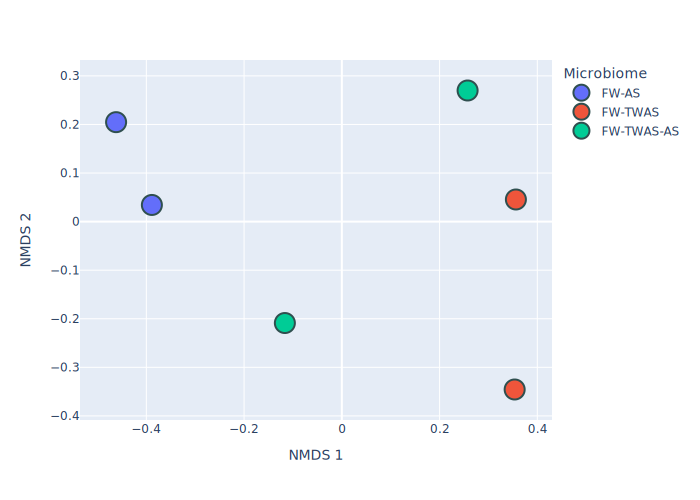

In [50]:
fig=px.scatter(X,x=0,y=1,color="Microbiome")
fig.update_traces(
    marker=dict(size=20,
                line=dict(width=2,
                color='DarkSlateGrey')))

fig.update_layout(xaxis={"title":"NMDS 1"},
                  yaxis={"title":"NMDS 2"})
fig.show(renderer="svg")


In [51]:
fig.write_image("NMDS_wastewater.svg")

Separation of samples in different treament groups is a good sign that different microbiome sources are functionally different and might be used to predict the difference in VFA profiles.

- FW_TWAS_rep_1

In [52]:
from adtoolbox import utils
local_params=dict(
    model_parameters="./Database/ADM_Parameters/Modified_ADM_Model_Parameters.json",
    base_parameters="./Database/ADM_Parameters/Modified_ADM_Base_Parameters.json",
    initial_conditions="./Database/ADM_Parameters/Modified_ADM_Initial_Conditions.json",
    inlet_conditions="./Database/ADM_Parameters/Modified_ADM_Inlet_Conditions.json",
    species="./Database/ADM_Parameters/Modified_ADM_Species.json",
    reactions="./Database/ADM_Parameters/Modified_ADM_Reactions.json",
)
params=utils.load_multiple_json_files(local_params) #just a helper function to load multiple json files.
initial_conditions=params.initial_conditions

In [53]:
s_h_ion=10**(-feedstock_pH)
ic_fw_twas_rep_1=initial_conditions.copy()
ic_fw_twas_rep_1['S_va_ion']=   params.model_parameters['K_a_va']  /(params.model_parameters['K_a_va']+ s_h_ion)*ic_fw_twas_rep_1['S_va'] 
ic_fw_twas_rep_1['S_bu_ion']=   params.model_parameters['K_a_bu']  /(params.model_parameters['K_a_bu']+ s_h_ion)*ic_fw_twas_rep_1['S_bu'] 
ic_fw_twas_rep_1['S_pro_ion']=  params.model_parameters['K_a_pro'] /(params.model_parameters['K_a_pro']+s_h_ion)*ic_fw_twas_rep_1['S_pro']
ic_fw_twas_rep_1['S_cap_ion']=  params.model_parameters['K_a_cap'] /(params.model_parameters['K_a_cap']+s_h_ion)*ic_fw_twas_rep_1['S_cap']
ic_fw_twas_rep_1['S_ac_ion']=   params.model_parameters['K_a_ac']  /(params.model_parameters['K_a_ac']+ s_h_ion)*ic_fw_twas_rep_1['S_ac'] 
ic_fw_twas_rep_1['S_lac_ion']=  params.model_parameters['K_a_lac'] /(params.model_parameters['K_a_lac']+s_h_ion)*ic_fw_twas_rep_1['S_lac']  
ic_fw_twas_rep_1.update({k:v*TWAS for k,v in normalized_cods[sample_id_dict_rev['FW_TWAS_rep_1']].items()})
ic_fw_twas_rep_1["TSS"]=TSS
ic_fw_twas_rep_1["TDS"]=TDS
ic_fw_twas_rep_1["S_su"]=0
ic_fw_twas_rep_1["S_aa"]=0
ic_fw_twas_rep_1["S_fa"]=0

data=[]
data.append(acetic_acid.loc["FW+TWAS_rep_1"].to_list())
data.append(propionic_acid.loc["FW+TWAS_rep_1"].to_list())
data.append(butyric_acid.loc["FW+TWAS_rep_1"].to_list())
data.append(valeric_acid.loc["FW+TWAS_rep_1"].to_list())
data.append(caproic_acid.loc["FW+TWAS_rep_1"].to_list())


exp_ic_fw_twas_rep_1=core.Experiment(
    name="fw_twas_rep_1",
    initial_concentrations=ic_fw_twas_rep_1,
    time=acetic_acid.columns.astype(int).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1021/acssuschemeng.2c04080"
)

- FW_TWAS_rep_2

In [54]:

ic_fw_twas_rep_2=initial_conditions.copy()
ic_fw_twas_rep_2['S_va_ion']=   params.model_parameters['K_a_va']  /(params.model_parameters['K_a_va']+ s_h_ion)*ic_fw_twas_rep_2['S_va'] 
ic_fw_twas_rep_2['S_bu_ion']=   params.model_parameters['K_a_bu']  /(params.model_parameters['K_a_bu']+ s_h_ion)*ic_fw_twas_rep_2['S_bu'] 
ic_fw_twas_rep_2['S_pro_ion']=  params.model_parameters['K_a_pro'] /(params.model_parameters['K_a_pro']+s_h_ion)*ic_fw_twas_rep_2['S_pro']
ic_fw_twas_rep_2['S_cap_ion']=  params.model_parameters['K_a_cap'] /(params.model_parameters['K_a_cap']+s_h_ion)*ic_fw_twas_rep_2['S_cap']
ic_fw_twas_rep_2['S_ac_ion']=   params.model_parameters['K_a_ac']  /(params.model_parameters['K_a_ac']+ s_h_ion)*ic_fw_twas_rep_2['S_ac'] 
ic_fw_twas_rep_2['S_lac_ion']=  params.model_parameters['K_a_lac'] /(params.model_parameters['K_a_lac']+s_h_ion)*ic_fw_twas_rep_2['S_lac']  
ic_fw_twas_rep_2.update({k:v*TWAS for k,v in normalized_cods[sample_id_dict_rev['FW_TWAS_rep_2']].items()})
ic_fw_twas_rep_2["TSS"]=TSS
ic_fw_twas_rep_2["TDS"]=TDS
data=[]
data.append(acetic_acid.loc["FW+TWAS_rep_2"].to_list())
data.append(propionic_acid.loc["FW+TWAS_rep_2"].to_list())
data.append(butyric_acid.loc["FW+TWAS_rep_2"].to_list())
data.append(valeric_acid.loc["FW+TWAS_rep_2"].to_list())
data.append(caproic_acid.loc["FW+TWAS_rep_2"].to_list())


exp_ic_fw_twas_rep_2=core.Experiment(
    name="fw_twas_rep_2",
    initial_concentrations=ic_fw_twas_rep_2,
    time=acetic_acid.columns.astype(int).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1021/acssuschemeng.2c04080"
)

In [55]:
ic_fw_twas_as_rep_1=initial_conditions.copy()
ic_fw_twas_as_rep_1['S_va_ion']=   params.model_parameters['K_a_va']  /(params.model_parameters['K_a_va']+ s_h_ion)*ic_fw_twas_as_rep_1['S_va'] 
ic_fw_twas_as_rep_1['S_bu_ion']=   params.model_parameters['K_a_bu']  /(params.model_parameters['K_a_bu']+ s_h_ion)*ic_fw_twas_as_rep_1['S_bu'] 
ic_fw_twas_as_rep_1['S_pro_ion']=  params.model_parameters['K_a_pro'] /(params.model_parameters['K_a_pro']+s_h_ion)*ic_fw_twas_as_rep_1['S_pro']
ic_fw_twas_as_rep_1['S_cap_ion']=  params.model_parameters['K_a_cap'] /(params.model_parameters['K_a_cap']+s_h_ion)*ic_fw_twas_as_rep_1['S_cap']
ic_fw_twas_as_rep_1['S_ac_ion']=   params.model_parameters['K_a_ac']  /(params.model_parameters['K_a_ac']+ s_h_ion)*ic_fw_twas_as_rep_1['S_ac'] 
ic_fw_twas_as_rep_1['S_lac_ion']=  params.model_parameters['K_a_lac'] /(params.model_parameters['K_a_lac']+s_h_ion)*ic_fw_twas_as_rep_1['S_lac']  
ic_fw_twas_as_rep_1.update({k:v*TWAS_AS for k,v in normalized_cods[sample_id_dict_rev['FW_TWAS_AS_rep_1']].items()})
ic_fw_twas_as_rep_1["TSS"]=TSS
ic_fw_twas_as_rep_1["TDS"]=TDS
data=[]
data.append(acetic_acid.loc["FW+TWAS+AS_rep_1"].to_list())
data.append(propionic_acid.loc["FW+TWAS+AS_rep_1"].to_list())
data.append(butyric_acid.loc["FW+TWAS+AS_rep_1"].to_list())
data.append(valeric_acid.loc["FW+TWAS+AS_rep_1"].to_list())
data.append(caproic_acid.loc["FW+TWAS+AS_rep_1"].to_list())


exp_ic_fw_twas_as_rep_1=core.Experiment(
    name="fw_twas_as_rep_1",
    initial_concentrations=ic_fw_twas_as_rep_1,
    time=acetic_acid.columns.astype(int).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1021/acssuschemeng.2c04080"
)

In [56]:
ic_fw_twas_as_rep_2=initial_conditions.copy()
ic_fw_twas_as_rep_2['S_va_ion']=   params.model_parameters['K_a_va']  /(params.model_parameters['K_a_va']+ s_h_ion)*ic_fw_twas_as_rep_2['S_va'] 
ic_fw_twas_as_rep_2['S_bu_ion']=   params.model_parameters['K_a_bu']  /(params.model_parameters['K_a_bu']+ s_h_ion)*ic_fw_twas_as_rep_2['S_bu'] 
ic_fw_twas_as_rep_2['S_pro_ion']=  params.model_parameters['K_a_pro'] /(params.model_parameters['K_a_pro']+s_h_ion)*ic_fw_twas_as_rep_2['S_pro']
ic_fw_twas_as_rep_2['S_cap_ion']=  params.model_parameters['K_a_cap'] /(params.model_parameters['K_a_cap']+s_h_ion)*ic_fw_twas_as_rep_2['S_cap']
ic_fw_twas_as_rep_2['S_ac_ion']=   params.model_parameters['K_a_ac']  /(params.model_parameters['K_a_ac']+ s_h_ion)*ic_fw_twas_as_rep_2['S_ac'] 
ic_fw_twas_as_rep_2['S_lac_ion']=  params.model_parameters['K_a_lac'] /(params.model_parameters['K_a_lac']+s_h_ion)*ic_fw_twas_as_rep_2['S_lac']  
ic_fw_twas_as_rep_2.update({k:v*TWAS_AS for k,v in normalized_cods[sample_id_dict_rev['FW_TWAS_AS_rep_2']].items()})
ic_fw_twas_as_rep_2["TSS"]=TSS
ic_fw_twas_as_rep_2["TDS"]=TDS
data=[]
data.append(acetic_acid.loc["FW+TWAS+AS_rep_2"].to_list())
data.append(propionic_acid.loc["FW+TWAS+AS_rep_2"].to_list())
data.append(butyric_acid.loc["FW+TWAS+AS_rep_2"].to_list())
data.append(valeric_acid.loc["FW+TWAS+AS_rep_2"].to_list())
data.append(caproic_acid.loc["FW+TWAS+AS_rep_2"].to_list())

exp_ic_fw_twas_as_rep_2=core.Experiment(
    name="fw_twas_as_rep_2",
    initial_concentrations=ic_fw_twas_as_rep_2,
    time=acetic_acid.columns.astype(int).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1021/acssuschemeng.2c04080"
)

In [57]:
ic_fw_as_rep_1=initial_conditions.copy()
ic_fw_as_rep_1['S_va_ion']=   params.model_parameters['K_a_va']  /(params.model_parameters['K_a_va']+ s_h_ion)*ic_fw_as_rep_1['S_va'] 
ic_fw_as_rep_1['S_bu_ion']=   params.model_parameters['K_a_bu']  /(params.model_parameters['K_a_bu']+ s_h_ion)*ic_fw_as_rep_1['S_bu'] 
ic_fw_as_rep_1['S_pro_ion']=  params.model_parameters['K_a_pro'] /(params.model_parameters['K_a_pro']+s_h_ion)*ic_fw_as_rep_1['S_pro']
ic_fw_as_rep_1['S_cap_ion']=  params.model_parameters['K_a_cap'] /(params.model_parameters['K_a_cap']+s_h_ion)*ic_fw_as_rep_1['S_cap']
ic_fw_as_rep_1['S_ac_ion']=   params.model_parameters['K_a_ac']  /(params.model_parameters['K_a_ac']+ s_h_ion)*ic_fw_as_rep_1['S_ac'] 
ic_fw_as_rep_1['S_lac_ion']=  params.model_parameters['K_a_lac'] /(params.model_parameters['K_a_lac']+s_h_ion)*ic_fw_as_rep_1['S_lac'] 
ic_fw_as_rep_1.update({k:v*AS for k,v in normalized_cods[sample_id_dict_rev['FW_AS_rep_1']].items()})
ic_fw_as_rep_1["TSS"]=TSS
ic_fw_as_rep_1["TDS"]=TDS
data=[]
data.append(acetic_acid.loc["FW+AS_rep_1"].to_list())
data.append(propionic_acid.loc["FW+AS_rep_1"].to_list())
data.append(butyric_acid.loc["FW+AS_rep_1"].to_list())
data.append(valeric_acid.loc["FW+AS_rep_1"].to_list())
data.append(caproic_acid.loc["FW+AS_rep_1"].to_list())


exp_ic_fw_as_rep_1=core.Experiment(
    name="fw_as_rep_1",
    initial_concentrations=ic_fw_as_rep_1,
    time=acetic_acid.columns.astype(int).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1021/acssuschemeng.2c04080"
)

In [58]:
ic_fw_as_rep_2=initial_conditions.copy()
ic_fw_as_rep_2['S_va_ion']=   params.model_parameters['K_a_va']  /(params.model_parameters['K_a_va']+ s_h_ion)*ic_fw_as_rep_2['S_va'] 
ic_fw_as_rep_2['S_bu_ion']=   params.model_parameters['K_a_bu']  /(params.model_parameters['K_a_bu']+ s_h_ion)*ic_fw_as_rep_2['S_bu'] 
ic_fw_as_rep_2['S_pro_ion']=  params.model_parameters['K_a_pro'] /(params.model_parameters['K_a_pro']+s_h_ion)*ic_fw_as_rep_2['S_pro']
ic_fw_as_rep_2['S_cap_ion']=  params.model_parameters['K_a_cap'] /(params.model_parameters['K_a_cap']+s_h_ion)*ic_fw_as_rep_2['S_cap']
ic_fw_as_rep_2['S_ac_ion']=   params.model_parameters['K_a_ac']  /(params.model_parameters['K_a_ac']+ s_h_ion)*ic_fw_as_rep_2['S_ac'] 
ic_fw_as_rep_2['S_lac_ion']=  params.model_parameters['K_a_lac'] /(params.model_parameters['K_a_lac']+s_h_ion)*ic_fw_as_rep_2['S_lac'] 
ic_fw_as_rep_2.update({k:v*AS for k,v in normalized_cods[sample_id_dict_rev['FW_AS_rep_2']].items()})
ic_fw_as_rep_2["TSS"]=TSS
ic_fw_as_rep_2["TDS"]=TDS
data=[]
data.append(acetic_acid.loc["FW+AS_rep_2"].to_list())
data.append(propionic_acid.loc["FW+AS_rep_2"].to_list())
data.append(butyric_acid.loc["FW+AS_rep_2"].to_list())
data.append(valeric_acid.loc["FW+AS_rep_2"].to_list())
data.append(caproic_acid.loc["FW+AS_rep_2"].to_list())


exp_ic_fw_as_rep_2=core.Experiment(
    name="fw_as_rep_2",
    initial_concentrations=ic_fw_as_rep_2,
    time=acetic_acid.columns.astype(int).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1021/acssuschemeng.2c04080"
)

In [59]:
for exp in [exp_ic_fw_twas_rep_1,exp_ic_fw_twas_rep_2,exp_ic_fw_twas_as_rep_1,exp_ic_fw_twas_as_rep_2,exp_ic_fw_as_rep_1,exp_ic_fw_as_rep_2]:
    try:
        db.add_experiment_to_experiments_db(exp)
    except:
        print('Experiment already in database')

Experiment already in database
Experiment already in database
Experiment already in database
Experiment already in database
Experiment already in database
Experiment already in database


Now, we have to add the studies performed by Rico et al. (2021). This study used cellulosic material in all of the experiments:

In [60]:
feed_cellulose=core.Feed(
    name="Cellulosic Medium",
    carbohydrates=100,
    proteins=0,
    lipids=0,
    xi=0,
    si=0,
    tss=100,
    reference="https://doi.org/10.1016/j.biortech.2020.124532"   
)

try:
    db.add_feed_to_feed_db(feed_cellulose)
except:
    print("Feed already in database")

Feed already in database


This study uses 2g of cellulose in 90 ml of the solution but there is no measured COD. We can approximate the gCOD/l concentration by using the predefined seed component. The seed id for Cellulose is "cpd11746"

In [61]:
from adtoolbox.core import SeedDB

In [62]:
cellulose=SeedDB(config=configs.Database()).instantiate_metabs("cpd11746")

Now we see how easier this COD conversion calculation is because the conversion factor is already calculated automatically:

In [63]:
cellulose.cod

1.1707317073170733

In [64]:
TOTAL_FEED_COD_CELLULOSE=2/0.09*cellulose.cod
TDS_CELLULOSE=0
TSS_CELLULOSE=TOTAL_FEED_COD_CELLULOSE*feed_cellulose.tss/100

This paper does not include an estimate of inoculum total COD. However we know that this COD is approximately the same between different reactor and treatments because of the DNA normalization method that they have used. There doesn't seem to be a choice but using a reasonable COD concantration for all reactors as a result. This might affect the quantitative results but still probably won't affect the qualitative results as much. What we use here will be the ratio of the volume of the feedstock, 75 ml, to inoculum, 15 ml.


In [65]:
INOCULUM_COD=TOTAL_FEED_COD_CELLULOSE/75*15

Now We have everything that we need to add these studies to the studies database! First we can load the relative COD portions recovered from the 16s studies.

In [66]:
with open("samples_cod_normalized_rico.json","r") as f:
    samples_cod=json.load(f)
samples_cod=pd.DataFrame(samples_cod)
samples_cod.loc["X_VFA_deg"]=0.1
samples_cod=samples_cod/samples_cod.sum(axis=0)
samples_cod=samples_cod.to_dict(orient="dict")

Let's draw an NMDS plot for this dataset as well:

In [67]:
df_cods=pd.DataFrame(samples_cod).T

In [68]:
df_cods=df_cods[df_cods.index.map(lambda x: True if "D00" in x and "Fed" in x else False)]
ans=calculate_dist(df_cods)

In [69]:
X=pd.DataFrame(nmds.fit_transform(ans.to_numpy()),index=ans.index)

In [70]:
X["group"]=X.index.map(lambda x: x[0])

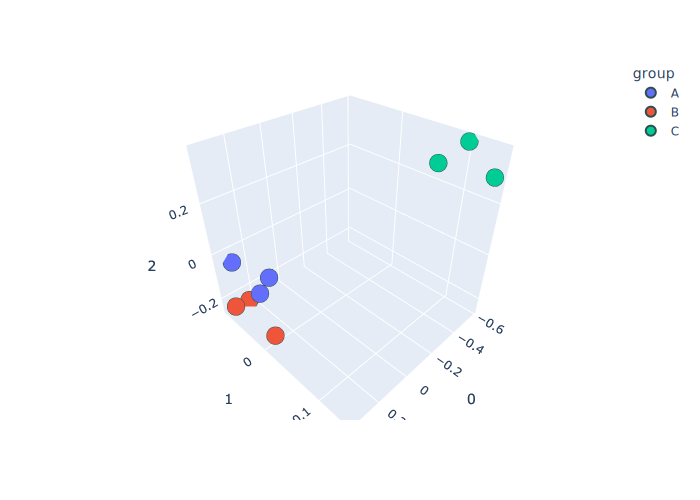

In [71]:
fig=px.scatter_3d(X,x=0,y=1,z=2,color="group")
fig.update_traces(
    marker=dict(size=10,
                line=dict(width=2,
                color='DarkSlateGrey')
                ))
fig.show(renderer="svg")



The plot above shows the difference between different microbiomes. We can convert the relative values to absolute values:



In [72]:
for sample,rel_dict in samples_cod.items():
    samples_cod[sample]={k:
        INOCULUM_COD*v for k,v in rel_dict.items()}

Now, in order to build study objects from the experimental data we need to load the metadata associated with this study:


In [73]:
metadata_rico=pd.read_table("MetadataFile_S1.txt")

In [74]:
metadata_rico=metadata_rico[(metadata_rico["Cellulose"]=="Fed")] #We don't care about controls for in-silico analysis

In [75]:
metadata_rico_grouped=metadata_rico.groupby(["Reactor","Replicate","Day"])

In [76]:
ic_cell_a_1=initial_conditions.copy()
ic_cell_a_1["S_su"]=0
ic_cell_a_1["S_aa"]=0
ic_cell_a_1["S_fa"]=0
ic_cell_a_1.update(samples_cod["A_Fed_D00_1"])
ic_cell_a_1["TSS"]=TSS_CELLULOSE
ic_cell_a_1["TDS"]=TDS_CELLULOSE
data=[]
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","1"))["Acetic_Acid"].astype(float)*cod_dict["S_ac"]*mw_dict["S_ac"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","1"))["Propionic_Acid"].astype(float)*cod_dict["S_pro"]*mw_dict["S_pro"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","1"))["Butyric_Acid"].astype(float)*cod_dict["S_bu"]*mw_dict["S_bu"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","1"))["Valeric_Acid"].astype(float)*cod_dict["S_va"]*mw_dict["S_va"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","1"))["Caproic_Acid"].astype(float)*cod_dict["S_cap"]*mw_dict["S_cap"])


exp_ic_cell_a_1=core.Experiment(
    name="ic_cell_a_1",
    initial_concentrations=ic_cell_a_1,
    time=metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","1"))["Day"].astype(float).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1016/j.biortech.2020.124532"
)

In [77]:
ic_cell_a_2=initial_conditions.copy()
ic_cell_a_2["S_cation"]=0.1
ic_cell_a_2["S_su"]=0
ic_cell_a_2["S_aa"]=0
ic_cell_a_2["S_fa"]=0
ic_cell_a_2.update(samples_cod["A_Fed_D00_2"])
ic_cell_a_2["TSS"]=TSS_CELLULOSE
ic_cell_a_2["TDS"]=TDS_CELLULOSE
data=[]
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","2"))["Acetic_Acid"].astype(float)*cod_dict["S_ac"]*mw_dict["S_ac"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","2"))["Propionic_Acid"].astype(float)*cod_dict["S_pro"]*mw_dict["S_pro"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","2"))["Butyric_Acid"].astype(float)*cod_dict["S_bu"]*mw_dict["S_bu"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","2"))["Valeric_Acid"].astype(float)*cod_dict["S_va"]*mw_dict["S_va"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","2"))["Caproic_Acid"].astype(float)*cod_dict["S_cap"]*mw_dict["S_cap"])


exp_ic_cell_a_2=core.Experiment(
    name="ic_cell_a_2",
    initial_concentrations=ic_cell_a_2,
    time=metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","2"))["Day"].astype(float).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1016/j.biortech.2020.124532"
)

In [78]:
ic_cell_a_3=initial_conditions.copy()
ic_cell_a_3["S_cation"]=0.1
ic_cell_a_3["S_su"]=0
ic_cell_a_3["S_aa"]=0
ic_cell_a_3["S_fa"]=0
ic_cell_a_3.update(samples_cod["A_Fed_D00_3"])
ic_cell_a_3["TSS"]=TSS_CELLULOSE
ic_cell_a_3["TDS"]=TDS_CELLULOSE
data=[]
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","3"))["Acetic_Acid"].astype(float)*mw_dict["S_ac"]*cod_dict["S_ac"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","3"))["Propionic_Acid"].astype(float)*cod_dict["S_pro"]*mw_dict["S_pro"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","3"))["Butyric_Acid"].astype(float)*cod_dict["S_bu"]*mw_dict["S_bu"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","3"))["Valeric_Acid"].astype(float)*cod_dict["S_va"]*mw_dict["S_va"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","3"))["Caproic_Acid"].astype(float)*cod_dict["S_cap"]*mw_dict["S_cap"])


exp_ic_cell_a_3=core.Experiment(
    name="ic_cell_a_3",
    initial_concentrations=ic_cell_a_3,
    time=metadata_rico.groupby(["Reactor","Replicate"]).get_group(("A","3"))["Day"].astype(float).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1016/j.biortech.2020.124532"
)

Same for B reactor!

In [79]:
ic_cell_b_1=initial_conditions.copy()
ic_cell_b_1["S_cation"]=0.1
ic_cell_b_1["S_su"]=0
ic_cell_b_1.update(samples_cod["B_Fed_D00_1"])
ic_cell_b_1["TSS"]=TSS_CELLULOSE
ic_cell_b_1["TDS"]=TDS_CELLULOSE
data=[]
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","1"))["Acetic_Acid"].astype(float)*cod_dict["S_ac"]*mw_dict["S_ac"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","1"))["Propionic_Acid"].astype(float)*cod_dict["S_pro"]*mw_dict["S_pro"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","1"))["Butyric_Acid"].astype(float)*cod_dict["S_bu"]*mw_dict["S_bu"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","1"))["Valeric_Acid"].astype(float)*cod_dict["S_va"]*mw_dict["S_va"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","1"))["Caproic_Acid"].astype(float)*cod_dict["S_cap"]*mw_dict["S_cap"])


exp_ic_cell_b_1=core.Experiment(
    name="ic_cell_b_1",
    initial_concentrations=ic_cell_b_1,
    time=metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","1"))["Day"].astype(float).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1016/j.biortech.2020.124532"
)
#########################################
ic_cell_b_2=initial_conditions.copy()
ic_cell_b_2["S_cation"]=0.1
ic_cell_b_2["S_su"]=0
ic_cell_b_2.update(samples_cod["B_Fed_D00_2"])
ic_cell_b_2["TSS"]=TSS_CELLULOSE
ic_cell_b_2["TDS"]=TDS_CELLULOSE
data=[]
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","2"))["Acetic_Acid"].astype(float)*cod_dict["S_ac"]*mw_dict["S_ac"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","2"))["Propionic_Acid"].astype(float)*cod_dict["S_pro"]*mw_dict["S_pro"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","2"))["Butyric_Acid"].astype(float)*cod_dict["S_bu"]*mw_dict["S_bu"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","2"))["Valeric_Acid"].astype(float)*cod_dict["S_va"]*mw_dict["S_va"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","2"))["Caproic_Acid"].astype(float)*cod_dict["S_cap"]*mw_dict["S_cap"])


exp_ic_cell_b_2=core.Experiment(
    name="ic_cell_b_2",
    initial_concentrations=ic_cell_b_2,
    time=metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","2"))["Day"].astype(float).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1016/j.biortech.2020.124532"
)

##############################
ic_cell_b_3=initial_conditions.copy()
ic_cell_b_3["S_su"]=0
ic_cell_b_3["S_cation"]=0.1
ic_cell_b_3.update(samples_cod["B_Fed_D00_3"])
ic_cell_b_3["TSS"]=TSS_CELLULOSE
ic_cell_b_3["TDS"]=TDS_CELLULOSE
data=[]
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","3"))["Acetic_Acid"].astype(float)*cod_dict["S_ac"]*mw_dict["S_ac"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","3"))["Propionic_Acid"].astype(float)*cod_dict["S_pro"]*mw_dict["S_pro"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","3"))["Butyric_Acid"].astype(float)*cod_dict["S_bu"]*mw_dict["S_bu"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","3"))["Valeric_Acid"].astype(float)*cod_dict["S_va"]*mw_dict["S_va"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","3"))["Caproic_Acid"].astype(float)*cod_dict["S_cap"]*mw_dict["S_cap"])


exp_ic_cell_b_3=core.Experiment(
    name="ic_cell_b_3",
    initial_concentrations=ic_cell_b_3,
    time=metadata_rico.groupby(["Reactor","Replicate"]).get_group(("B","3"))["Day"].astype(float).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1016/j.biortech.2020.124532"
)

Finally, Same for C!

In [80]:
ic_cell_c_1=initial_conditions.copy()
ic_cell_c_1["S_cation"]=0.1
ic_cell_c_1["S_su"]=0
ic_cell_c_1.update(samples_cod["C_Fed_D00_1"])
ic_cell_c_1["TSS"]=TSS_CELLULOSE
ic_cell_c_1["TDS"]=TDS_CELLULOSE
data=[]
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","1"))["Acetic_Acid"].astype(float)*cod_dict["S_ac"]*mw_dict["S_ac"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","1"))["Propionic_Acid"].astype(float)*cod_dict["S_pro"]*mw_dict["S_pro"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","1"))["Butyric_Acid"].astype(float)*cod_dict["S_bu"]*mw_dict["S_bu"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","1"))["Valeric_Acid"].astype(float)*cod_dict["S_va"]*mw_dict["S_va"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","1"))["Caproic_Acid"].astype(float)*cod_dict["S_cap"]*mw_dict["S_cap"])


exp_ic_cell_c_1=core.Experiment(
    name="ic_cell_c_1",
    initial_concentrations=ic_cell_c_1,
    time=metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","1"))["Day"].astype(float).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1016/j.biortech.2020.124532"
)
#########################################
ic_cell_c_2=initial_conditions.copy()
ic_cell_c_2["S_cation"]=0.1
ic_cell_c_2["S_su"]=0
ic_cell_c_2.update(samples_cod["C_Fed_D00_2"])
ic_cell_c_2["TSS"]=TSS_CELLULOSE
ic_cell_c_2["TDS"]=TDS_CELLULOSE
data=[]
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","2"))["Acetic_Acid"].astype(float)*cod_dict["S_ac"]*mw_dict["S_ac"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","2"))["Propionic_Acid"].astype(float)*cod_dict["S_pro"]*mw_dict["S_pro"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","2"))["Butyric_Acid"].astype(float)*cod_dict["S_bu"]*mw_dict["S_bu"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","2"))["Valeric_Acid"].astype(float)*cod_dict["S_va"]*mw_dict["S_va"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","2"))["Caproic_Acid"].astype(float)*cod_dict["S_cap"]*mw_dict["S_cap"])


exp_ic_cell_c_2=core.Experiment(
    name="ic_cell_c_2",
    initial_concentrations=ic_cell_c_2,
    time=metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","2"))["Day"].astype(float).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1016/j.biortech.2020.124532"
)

##############################
ic_cell_c_3=initial_conditions.copy()
ic_cell_c_3["S_cation"]=0.1
ic_cell_c_3["S_su"]=0
ic_cell_c_3.update(samples_cod["C_Fed_D00_3"])
ic_cell_c_3["TSS"]=TSS_CELLULOSE
ic_cell_c_3["TDS"]=TDS_CELLULOSE
data=[]
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","3"))["Acetic_Acid"].astype(float)*cod_dict["S_ac"]*mw_dict["S_ac"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","3"))["Propionic_Acid"].astype(float)*cod_dict["S_pro"]*mw_dict["S_pro"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","3"))["Butyric_Acid"].astype(float)*cod_dict["S_bu"]*mw_dict["S_bu"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","3"))["Valeric_Acid"].astype(float)*cod_dict["S_va"]*mw_dict["S_va"])
data.append(metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","3"))["Caproic_Acid"].astype(float)*cod_dict["S_cap"]*mw_dict["S_cap"])


exp_ic_cell_c_3=core.Experiment(
    name="ic_cell_c_3",
    initial_concentrations=ic_cell_c_3,
    time=metadata_rico.groupby(["Reactor","Replicate"]).get_group(("C","3"))["Day"].astype(float).to_list(),
    variables=[params.species.index(i) for i in tracked_species],
    data=data,
    reference="https://doi.org/10.1016/j.biortech.2020.124532"
)

In [81]:
train_data_cell=[exp_ic_cell_a_1,exp_ic_cell_a_2,exp_ic_cell_a_3,exp_ic_cell_b_1,exp_ic_cell_b_2,exp_ic_cell_b_3,exp_ic_cell_c_1,exp_ic_cell_c_2,exp_ic_cell_c_3]
for exp in train_data_cell:
    try:
        db.add_experiment_to_experiments_db(exp)
    except:
        print('Experiment already in database')

Experiment already in database
Experiment already in database
Experiment already in database
Experiment already in database
Experiment already in database
Experiment already in database
Experiment already in database
Experiment already in database
Experiment already in database


## Optimization

We have done most of the work and the rest is just instantiating a Tuner object to carry out the optimization!

In [82]:
from adtoolbox import optimize,adm,utils

In [83]:
local_params=dict(
    model_parameters="./Database/ADM_Parameters/Modified_ADM_Model_Parameters.json",
    base_parameters="./Database/ADM_Parameters/Modified_ADM_Base_Parameters.json",
    initial_conditions="./Database/ADM_Parameters/Modified_ADM_Initial_Conditions.json",
    inlet_conditions="./Database/ADM_Parameters/Modified_ADM_Inlet_Conditions.json",
    species="./Database/ADM_Parameters/Modified_ADM_Species.json",
    reactions="./Database/ADM_Parameters/Modified_ADM_Reactions.json",
)
params=utils.load_multiple_json_files(local_params)

base_model=adm.Model(model_parameters=params.model_parameters,
                     base_parameters=params.base_parameters,
                     initial_conditions=params.initial_conditions,
                    inlet_conditions=params.inlet_conditions,
                     species=params.species,
                     reactions=params.reactions,
                     feed=feed,
                    build_stoichiometric_matrix=adm.build_e_adm_2_stoichiometric_matrix,
                    ode_system=adm.e_adm_2_ode_sys,
                    simulation_time=30)           
                    
base_model.update_parameters(base_parameters={"q_in":0,"V_liq":0.0001,"V_gas":0.00007},model_parameters={"k_p":0})

In [84]:
train_data=[exp_ic_fw_twas_rep_1,exp_ic_fw_twas_rep_2,exp_ic_fw_twas_as_rep_1,exp_ic_fw_twas_as_rep_2,exp_ic_fw_as_rep_1,exp_ic_fw_as_rep_2]

In [85]:
#The model parameters to be calibrated:
tunables={
          "f_pro_su": (0.2,0.45), 
          "f_et_su": (0.01,0.3), 
          "f_lac_su": (0.1,0.3), 
          "K_pH_ac":(0.001,0.1),
          "Y_su": (0.01,0.3), 
          "K_S_su": (1,10),
          "K_S_ac": (1,10),
          "K_S_pro": (1,10),
          "K_I_h2_ox": (1e-8,1000),
          "K_I_h2_c4": (1e-8,10),
          "K_I_h2_pro": (1e-8,100),
          "K_I_h2_fa":(1e-8,10),
          "f_co2_ch4":(-1,-0.000001),
          "K_S_IN": (1e-5,10),
          "f_pro_aa": (0.1,0.7),
          "f_et_aa": (0.0001,0.2),
          "f_lac_aa": (0.01,0.3),
          "Y_ac_et": (0.01,0.2),  
          "f_et_ac": (-0.3,-0.15),
          "f_bu_ac": (0.6,1), 
          "Y_ac_lac": (0.1,0.4), 
          "f_lac_ac": (-0.3,-0.01),
          "f_h2_ac": (0.1,0.2),
          "Y_ac_et_ox":(0.1,0.3), 
          "Y_pro_lac_ox": (0.01,0.3), 
          "Y_pro_et": (0.01,0.3),  
          "f_et_pro": (-1,-0.15), 
          "f_va_pro": (0.8,1), 
          "Y_pro_lac": (0.01,0.3),
          "f_lac_pro": (-0.5,-0.15),
          "f_h2_pro": (0.01,0.2), 
          "Y_chain_et_pro": (0.01,0.3),  
          "Y_chain_lac_pro": (0.01,0.3),  
          "Y_bu_et": (0.01,0.3),  
          "f_et_bu": (-1,-0.1), 
          "f_cap_bu": (0.6,1),
          "Y_bu_lac": (0.1,0.8), 
          "f_lac_bu": (-1,-0.1), 
          "f_h2_bu": (0.01,0.2), 
          "Y_va": (0.1,0.3), 
          "Y_cap": (0.2,0.6),
          "Y_h2_ac": (0.1,0.3),
          "Y_h2_CO2": (0.1,0.3), 
          "f_ac_h2": (-2,-0.5),
          "Y_Me_ac": (0.1,0.3), 
          "Y_Me_CO2": (0.1,0.3), 
          "Y_Me_h2": (0.1,0.3), 
          "Y_aa": (0.01,0.3),
          "Y_fa": (0.01,0.3),
          "Y_ac": (0.01,0.5), 
          "k_dis_TSS": (0.01,0.5), 
          "k_dis_TDS": (0.1,10), 
          "k_hyd_ch": (0.01,15), 
          "k_hyd_pr": (0.01,15), 
          "k_hyd_li": (0.11,15), 
          "k_m_su": (1,50), 
          "K_S_su": (1,40), 
          "k_m_aa": (1,35), 
          "K_S_aa": (0.1,40), 
          "k_m_fa": (0.1,30), 
          "K_S_fa": (0.1,20), 
          "k_m_bu": (0.5,20), 
          "K_S_bu": (0.05,50), 
          "k_m_va": (0.1,2),  
          "K_S_va": (0.01,20),
          "k_m_cap": (0.01,5),
          "K_S_cap": (0.01,50),
          "k_m_pro": (1,40), 
          "K_S_pro": (0.01,20),
          "k_m_et": (1,50),
          "K_S_et": (1,150), 
          "k_m_lac": (0.1,30), 
          "K_S_lac": (0.01,100),
          "k_m_ac": (10,50), 
          "K_S_ac": (0.01,15),  
          "k_m_h2_Me_ac": (1,100), 
          "K_S_h2_Me_ac": (1e-06,1e-02),
          "K_S_ac_Me": (0.001,20),
          "k_m_h2_Me_CO2": (0.1,50), 
          "K_S_h2_Me_CO2": (1e-06,1e-02),
          "K_S_CO2_Me": (0.01,5),  
          "f_pro_fa": (0.2,0.6),
          "f_et_fa": (0,0.1),
          "f_lac_fa":(0,0.1),
          "k_L_a":(10,100),
          "K_S_ac_lac":(0.01,50),
          "K_S_ac_et":(0.01,10),
          "K_S_pro_et":(0.01,0.6),
          "K_S_bu_et":(0.01,0.6),
          "K_S_bu_lac":(0.01,0.6),
          "K_S_pro_lac": (0.01,0.6),
          'f_ac_h2':(-0.2,-0.01),
          "k_m_bu_deg":(0.1,10),
          "Y_bu":(0.01,10),
          "K_pH_aa":(0.0000001,10),
          "nn_aa":(0.1,10),
          'K_pH_ac':(0.0000001,10),
          'n_ac':(0.1,10),
          'K_pH_pro':(0.000001,10),
          'n_pro':(0.1,10),
          "K_pH_bu":(0.0000001,10),
          'n_bu':(0.1,50),    
          "K_pH_va":(0.0000001,10),
          'n_va':(0.1,10),    
          "K_pH_cap":(0.000001,10),
          'n_cap':(0.1,10),                 
 }




In [86]:
from adtoolbox.optimize import NNSurrogateTuner

Now we can instantiate the tuner object and run the optimization:

In [87]:
base_model.control_state={"S_H_ion":10**(-feedstock_pH)}
base_model.time_limit=10
test_nn=NNSurrogateTuner(
    base_model=base_model,
    train_data=train_data,
    tuneables=tunables,
    grad_steps=5,
    n_steps=5000,
    initial_points=50,
    exp_std=20,
    )
test_nn.load_history_file("history.pkl")  #Only if you want to continue from a previous run

In [ ]:
# history_nn_surogate=test_nn.optimize(perturbation_method="estimate_gradient_directions",ode_method="Radau") Run this line to start the optimization

In [88]:
import pickle
with open("./history.pkl","rb") as f:
    params=pickle.load(f)

In [89]:
min_index=params["cost"].index(min(params["cost"]))

In [90]:
m=base_model.copy()
m.update_parameters(model_parameters=dict(zip(tunables.keys(),params["parameters"][min_index])))


In [ ]:
m.control_state={"S_H_ion":10**(-feedstock_pH)}

In [ ]:
m.time_limit=-1 # Just to make sure the simulation won't stop before the end of the simulations

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/optimize.py:428: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/optimize.py:429: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



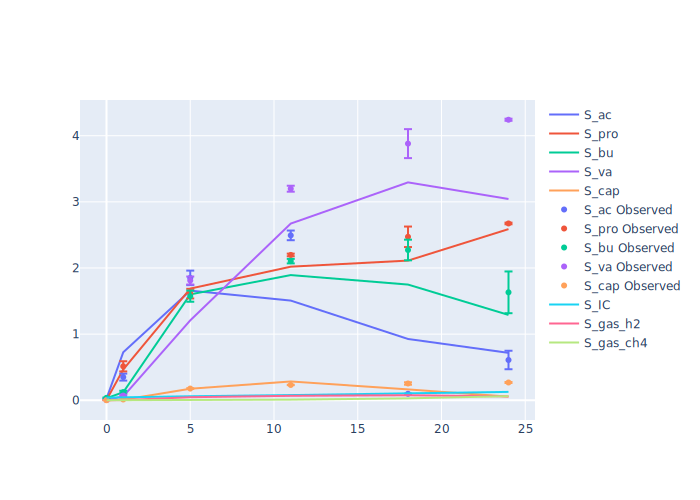

In [ ]:
fig_1=optimize.validate_model(m,train_data[0:2],plot=True,show_extra_states=["S_IC","S_gas_h2","S_gas_ch4"])

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/optimize.py:428: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/optimize.py:429: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



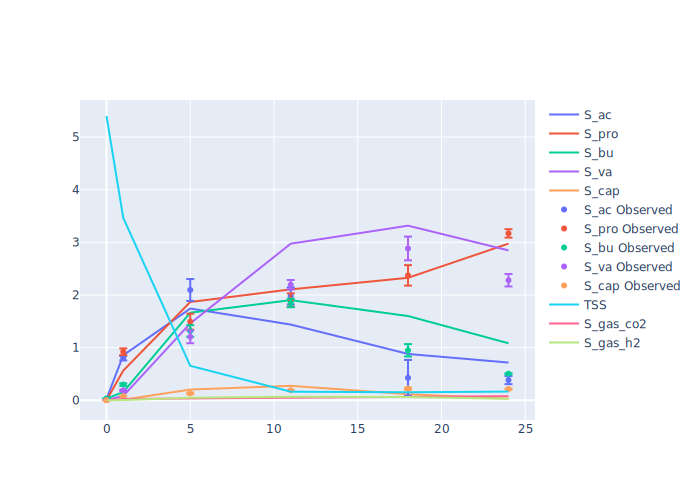

In [ ]:
fig_2=optimize.validate_model(m,train_data[2:4],plot=True,show_extra_states=["TSS","S_gas_co2","S_gas_h2"])


In [ ]:
fig_2[1]

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/optimize.py:428: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/optimize.py:429: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



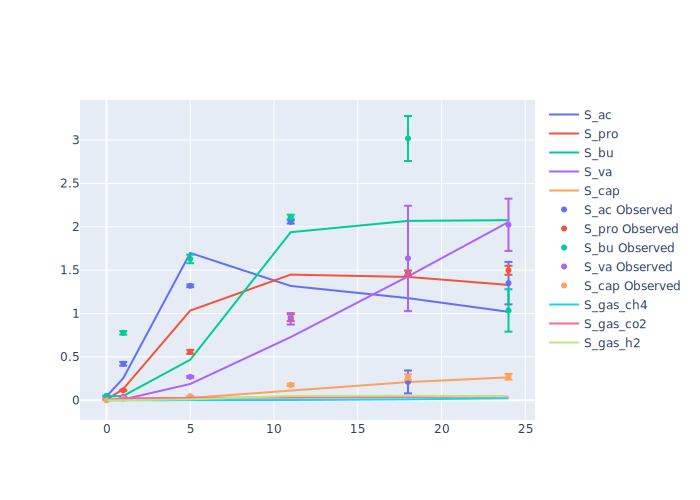

In [ ]:
fig_3=optimize.validate_model(m,train_data[4:],plot=True,show_extra_states=["S_gas_ch4","S_gas_co2","S_gas_h2"])


In [ ]:
fig_1[1].update_layout(title={"text":"Food Waste + TWAS","x":0.5},xaxis={"title":"time (day)"},yaxis={"title":"Concentration (gCOD/l)"}).write_image("fig1.svg")
fig_2[1].update_layout(title={"text":"Food Waste + TWAS + AS","x":0.5},xaxis={"title":"time (day)"},yaxis={"title":"Concentration (gCOD/l)"}).write_image("fig2.svg")
fig_3[1].update_layout(title={"text":"Food Waste + AS","x":0.5},xaxis={"title":"time (day)"},yaxis={"title":"Concentration (gCOD/l)"}).write_image("fig3.svg")


In [ ]:
optimize.calculate_fit_stats(m,train_data)

Validation(r_squared=0.8407184858534416, rmse=5.616288819179564)

## Exploring the effect of feedstock composition on butyric acid production 

In this study we will explore the effect fo feedstock composition on MAXIMUM butyric acid production.

TSS: 8 gCOD/l

TDS: 2 gCOD/l

Let's ignore the presence of inerts

si=0
xi=0

We need to create a matrix of random numbers between 0 and 100 for carbohydrates, lipids, and proteins

In [ ]:
ic=pd.DataFrame([exp_ic_cell_c_1.initial_concentrations.copy(),
exp_ic_cell_c_2.initial_concentrations.copy(),
exp_ic_cell_c_3.initial_concentrations.copy()]).mean().to_dict()
ic["TSS"]=8
ic["TDS"]=2
feeds=np.random.uniform([0,0,0],[100,100,100],size=(1000,3))
m.update_parameters(initial_conditions=ic)

In [ ]:
feed_space={
    "Carbs":[],
    "Lipids":[],
    "Proteins":[],
    "Butyric_acid":[],   
}
for ind,feed_ in enumerate(feeds):
    feed_=feed_/feed_.sum()*100-0.001
    feed_space["Carbs"].append(feed_[0])
    feed_space["Lipids"].append(feed_[1])
    feed_space["Proteins"].append(feed_[2])
    feed=core.Feed(
        "-",
        carbohydrates=feed_[0],
        lipids=feed_[1],
        proteins=feed_[2],
        si=0,
        xi=0,
        tss=80,
        reference="None"
        
    )
    m.feed=feed
    sol=m.solve_model(t_eval=[i for i in range(0,30,3)]).y
    feed_space["Butyric_acid"].append(max(sol[m.species.index("S_bu"),:]))
    print(ind,end="\r")
    
    

Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value


/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1701: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1745: RuntimeWarning:

invalid value encountered in matmul

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1704: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1707: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1716: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1713: RuntimeWarning:

overflow encountered in double_scalars



Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value


/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1710: RuntimeWarning:

overflow encountered in double_scalars



Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not 

In [ ]:
import plotly.express as px

In [ ]:
df_fs=pd.DataFrame(feed_space)

In [ ]:
df_fs=df_fs[df_fs["Butyric_acid"]<10] # Filter the instable points

In [ ]:
fig_base=px.scatter_ternary(df_fs,a="Carbs",b="Proteins",c="Lipids",color="Butyric_acid")

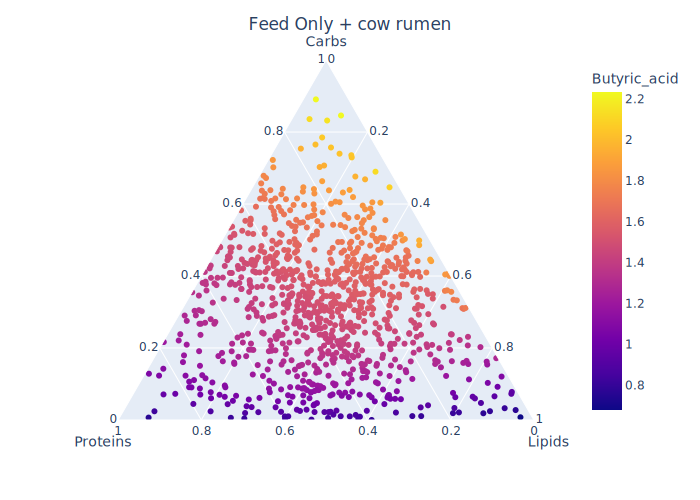

In [ ]:
fig_base.update_layout(
    title={
        "text":"Feed Only + cow rumen",
        "x":0.5
    }
)
fig_base.show(renderer="svg")

In [ ]:
fig_base.write_image("base_feed.svg")

In [ ]:
m.time_limit=100000
feed_space={
    "Carbs":[],
    "Lipids":[],
    "Proteins":[],
    "Butyric_acid":[],   
}
for ind,feed_ in enumerate(feeds):
    feed_=feed_/feed_.sum()*100-0.001
    feed_space["Carbs"].append(feed_[0])
    feed_space["Lipids"].append(feed_[1])
    feed_space["Proteins"].append(feed_[2])
    feed=core.Feed(
        "-",
        carbohydrates=feed_[0],
        lipids=feed_[1],
        proteins=feed_[2],
        si=0,
        xi=0,
        tss=80,
        reference="None"
        
    )
    m.feed=feed
    m.update_parameters(initial_conditions=ic)
    m.update_parameters(base_parameters={"q_in":0},initial_conditions={"S_ac":2})
    sol=m.solve_model(t_eval=[i for i in range(30)]).y
    feed_space["Butyric_acid"].append(max(sol[m.species.index("S_bu"),:]))
    print(ind,end="\r")
    
    

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1701: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1745: RuntimeWarning:

invalid value encountered in matmul

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1704: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1707: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1716: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1710: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1713: RuntimeWarning:

overflow encountered in double_scalars



Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not 

In [ ]:
df_fs=pd.DataFrame(feed_space)
df_fs=df_fs[df_fs["Butyric_acid"]<10000] # Filter the instable points

In [ ]:
fig_acetate=px.scatter_ternary(df_fs,a="Carbs",b="Proteins",c="Lipids",color="Butyric_acid")

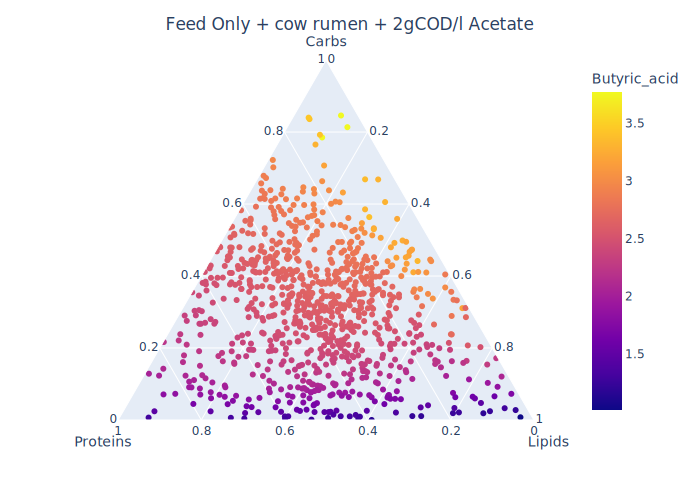

In [ ]:
fig_acetate.update_layout(
    title={
        "text":"Feed Only + cow rumen + 2gCOD/l Acetate",
        "x":0.5
    }
)

fig_acetate.show(renderer="svg")

In [ ]:
fig_acetate.write_image("./cow_rumen_acetate.svg")

In [ ]:
m=base_model.copy()
m.update_parameters(model_parameters=dict(zip(tunables.keys(),params["parameters"][min_index])))

feed_space={
    "Carbs":[],
    "Lipids":[],
    "Proteins":[],
    "Butyric_acid":[],   
}
for ind,feed_ in enumerate(feeds):
    feed_=feed_/feed_.sum()*100-0.001
    feed_space["Carbs"].append(feed_[0])
    feed_space["Lipids"].append(feed_[1])
    feed_space["Proteins"].append(feed_[2])
    feed=core.Feed(
        "-",
        carbohydrates=feed_[0],
        lipids=feed_[1],
        proteins=feed_[2],
        si=0,
        xi=0,
        tss=80,
        reference="None"
        
    )
    m.feed=feed
    m.update_parameters(initial_conditions=ic)
    m.update_parameters(base_parameters={"q_in":0},initial_conditions={"S_lac":2})
    sol=m.solve_model(t_eval=[i for i in range(30)]).y
    feed_space["Butyric_acid"].append(max(sol[m.species.index("S_bu"),:]))
    print(ind,end="\r")
    
    

Could not solve model, setting C to a very large value


/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1701: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1745: RuntimeWarning:

invalid value encountered in matmul

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1704: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1713: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1716: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1707: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1710: RuntimeWarning:

overflow encountered in double_scalars



Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not 

In [ ]:
df_fs=pd.DataFrame(feed_space)
df_fs=df_fs[df_fs["Butyric_acid"]<100000] # Filter the instable points

In [ ]:
fig_lactate=px.scatter_ternary(df_fs,a="Carbs",b="Proteins",c="Lipids",color="Butyric_acid")

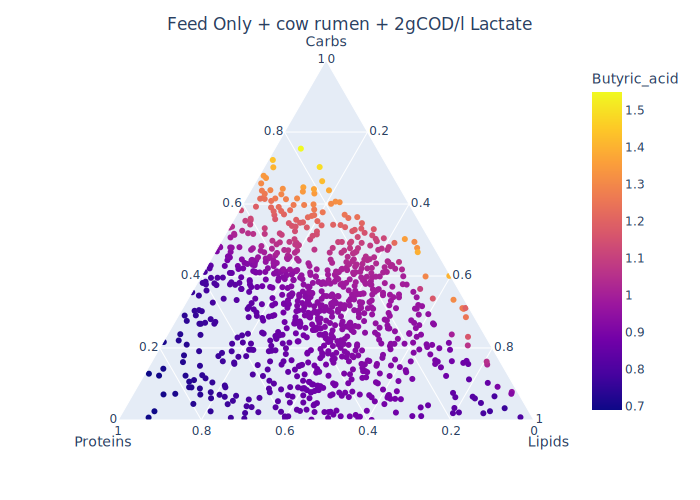

In [ ]:
fig_lactate.update_layout(
    title={
        "text":"Feed Only + cow rumen + 2gCOD/l Lactate",
        "x":0.5
    }
)
fig_lactate.show(renderer="svg")

In [ ]:
fig_lactate.write_image("./cow_rumen_lactate.svg")

The case studies above show that adding acetate to a protein-rich feedstock can increase butyric acid production. On the otehr hand, adding lactate to a carbohydrate-rich feedstock can increase butyric acid production when the microbiome is cow rumen. One reason could be that the experimental data used to calibrate the model parameters attribute lactate production to amino acid metabolism. However, the differences are sall in this case study. In the examples above we see that around 10% of the time the solutions become unstable. There are multiple ways to solve this problem. For example, we can change the Scipy solver or play with absolute and relative tolerance. Keep in mind that lowering the tolerance will increase the computation time.